<a href="https://colab.research.google.com/github/bjhaj/SkinCancerDetection/blob/master/SkinCancerDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()
# check to see if the file is there
!ls -lha kaggle.json
# install Kaggle API
!pip install kaggle --upgrade
# move file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# change permissions
!chmod 600 ~/.kaggle/kaggle.json
# download dataset
!kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign
#unzip dataset
!unzip skin-cancer-malignant-vs-benign.zip

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import Sequence
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import PIL
print(tf.__version__)


2.5.0


In [6]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
epochs = 200
batch_size = 128
IMG_HEIGHT=112 
IMG_WIDTH=122

train_dir = os.path.join('train')
validation_dir = os.path.join('test')
train_ben_dir = os.path.join(train_dir, 'benign')  # directory with our training benign pictures
train_mal_dir = os.path.join(train_dir, 'malignant')  # directory with our training malignant pictures
validation_ben_dir = os.path.join(validation_dir, 'benign')  # directory with our validation benign pictures
validation_mal_dir = os.path.join(validation_dir, 'malignant')  # directory with our validation malignant pictures

num_ben_tr = len(os.listdir(train_ben_dir))
num_mal_tr = len(os.listdir(train_mal_dir))

num_ben_val = len(os.listdir(validation_ben_dir))
num_mal_val = len(os.listdir(validation_mal_dir))

total_train = num_ben_tr + num_mal_tr
total_val = num_ben_val + num_mal_val
print('total training benign images:', num_ben_tr)
print('total training malignant images:', num_mal_tr)

print('total validation benign images:', num_ben_val)
print('total validation malignant images:', num_mal_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training benign images: 1440
total training malignant images: 1197
total validation benign images: 360
total validation malignant images: 300
--
Total training images: 2637
Total validation images: 660


Found 2637 images belonging to 2 classes.


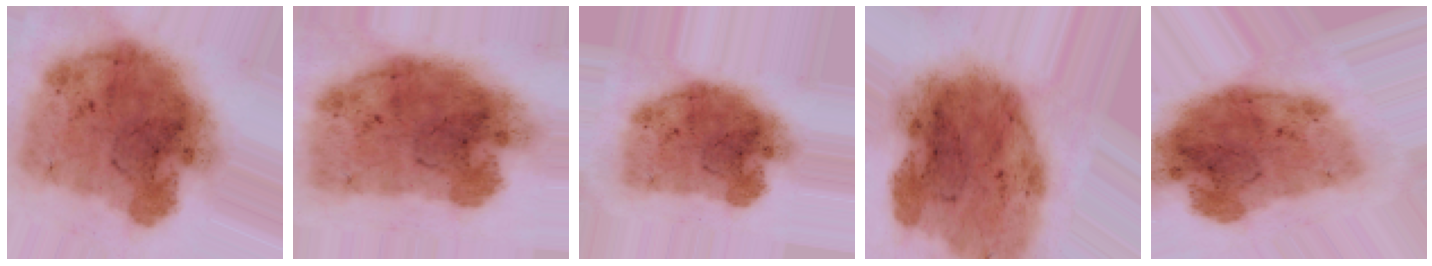

Found 660 images belonging to 2 classes.


In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')
#display augmented images
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

In [ ]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

#loss function shows how accurate our model is
#optimizer updates the model based on loss function and data it sees
#metrics - monitors training and testing steps (this example uses accuracy metric)
model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])
model.summary()
#fit the model to the training data
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)
model.summary()


In [ ]:
#evaluate to see accuracy
model.evaluate(train_data_gen)
model.evaluate(val_data_gen)

6/6 [==============================] - 1s 193ms/step - loss: 0.3109 - accuracy: 0.8742


[0.31091660261154175, 0.8742424249649048]

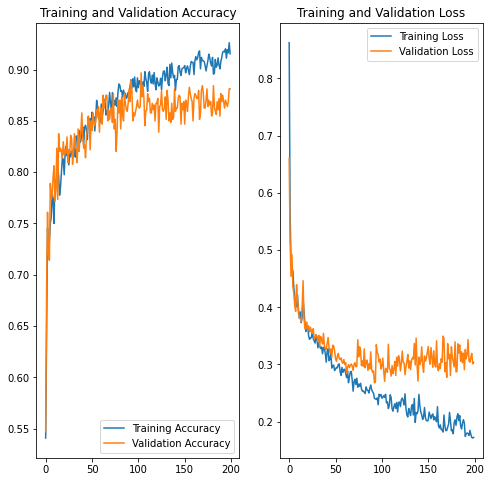

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
def plot(x, y, z):
  plt.figure(figsize=(8, 8))
  #plt.subplot(1, 2, 1)
  plt.plot(epochs_range, x, label=('Training' + z))
  plt.plot(epochs_range, y, label= ('Validation' + z))
  plt.legend(loc='lower right')
  plt.title('Training and Validation' + z)
  plt.show()
plot(acc, val_acc, 'Accuracy')
plot(loss, val_loss, 'Loss')

In [ ]:
#save the model to our google drive
from google.colab import drive
drive.mount('/content/drive')
path = path = F"/content/drive/My Drive/skincancermlproject" 


In [ ]:
model.save(path)

In [4]:
#import the model and evaluate its accuracy
import tensorflow as tf
new_model = tf.keras.models.load_model('/content/drive/My Drive/Image Classification/skincancermlproject/')

In [ ]:
new_model.evaluate(val_data_gen)

In [31]:
#make some predictions with the new model on our validation datasets. 
#Just change the directory and filename to chose any file. We can even upload our own.
filename = os.path.join(validation_mal_dir, '1005.jpg')

img = load_img(filename)
img = img.resize((IMG_WIDTH, IMG_HEIGHT), resample=PIL.Image.BICUBIC)
arr = img_to_array(img)
arr = np.expand_dims(arr, axis=0)
arr /= 255

prediction = new_model.predict(arr)
prediction = tf.constant(prediction)
predictions = (tf.keras.activations.sigmoid(prediction)).numpy()

if predictions > 0.5:
  print('the model finds this skin mole to be MALIGNANT with ', (round(((predictions[0][0])*100),2)), '% strength')
else:
  print('the model finds this skin mole to be BENIGN with ', (round(100-((predictions[0][0])*100),2)), '% strength')

the model finds this skin mole to be MALIGNANT with  98.77 % strength
